# Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import jax
import networkx as nx
import jax.numpy as jnp
import pandas as pd
from jax import random
from jax.lax import scan

This code generates a Networkx Graph that has the structure we want for the SNN. It generates a bunch of randomly connected neurons of which 80% are excitatory and 20% inhibitory. Further the sparsity of the network can be controlled. Additionally, an input layer of n neurons is added which is randomly connected to a subset of the main network with excitatory connections. 

/home/monika/PycharmProjects/masters/NMC-Project/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


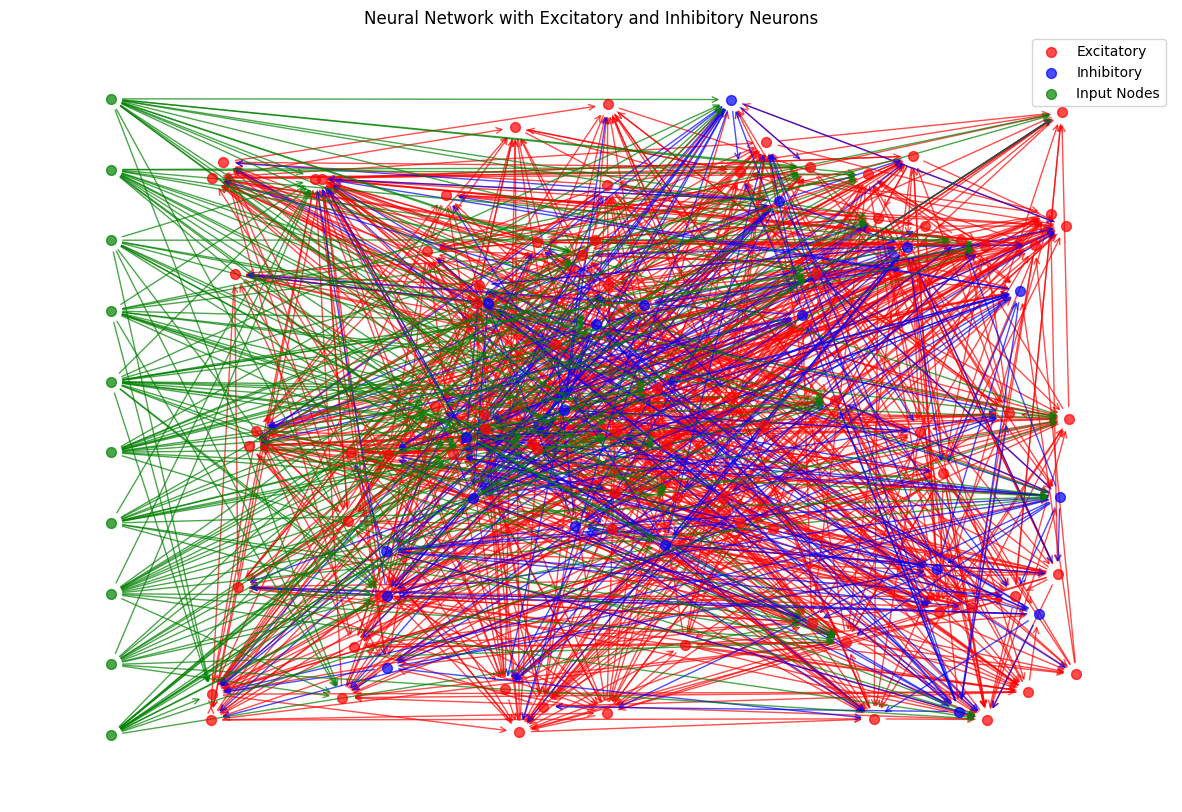

In [2]:

def generate_neural_network(num_neurons, excitatory_ratio=0.8, connection_prob=0.1):
    """
    Generates a neural network with excitatory and inhibitory neurons.

    Args:
        num_neurons (int): Total number of neurons.
        excitatory_ratio (float): Proportion of excitatory neurons (default: 0.8, for 4:1 ratio).
        connection_prob (float): Probability of connection between any two neurons.
    
    Returns:
        G (nx.DiGraph): Directed graph representing the network.
    """
    # Number of excitatory and inhibitory neurons
    num_excitatory = int(num_neurons * excitatory_ratio)
    num_inhibitory = num_neurons - num_excitatory

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes with attributes (excitatory or inhibitory)
    for i in range(num_neurons):
        if i < num_excitatory:
            G.add_node(i, type=1)
        else:
            G.add_node(i, type=-1)

    # Add edges with weights, respecting Dale's principle
    for i in range(num_neurons):
        for j in range(num_neurons):
            if i != j and np.random.rand() < connection_prob:
                if G.nodes[i]["type"] == 1:
                    weight = np.random.normal(5.0, 1.0)  # Positive weight for excitatory
                else:
                    weight = np.random.normal(-5.0, 1.0)  # Negative weight for inhibitory
                G.add_edge(i, j, weight=weight)
    
    # Ensure each excitatory or inhibitory neuron has at least one outgoing connection
    for i in range(num_neurons):
        if len(list(G.out_edges(i))) == 0:  # No outgoing connections
            # Find a random target neuron
            target = np.random.choice(num_neurons)
            while target == i:  # Ensure no self-loop
                target = np.random.choice(num_neurons)
            if G.nodes[i]["type"] == 1:
                weight = np.random.normal(5.0, 1.0)  # Positive weight for excitatory
            else:
                weight = np.random.normal(-5.0, 1.0)  # Negative weight for inhibitory
            G.add_edge(i, target, weight=weight)
    
    return G

def add_input_layer(G, num_input_nodes=10, subset_size=30, input_prob=0.5):
    """
    Adds an input layer to the neural network.

    Args:
        G (nx.DiGraph): Existing neural network graph.
        num_input_nodes (int): Number of input nodes to add.
        subset_size (int): Size of the subset of existing neurons to connect to.
        input_prob (float): Probability of connection from input nodes to subset neurons.

    Returns:
        G (nx.DiGraph): Updated graph with input layer.
    """
    num_existing_neurons = len(G.nodes)
    input_layer_start = num_existing_neurons

    # Add input nodes
    for i in range(num_input_nodes):
        G.add_node(input_layer_start + i, type=0)

    # Randomly select a subset of existing neurons
    subset_neurons = np.random.choice(num_existing_neurons, subset_size, replace=False)

    # Add edges from input nodes to subset neurons with the given probability
    for input_node in range(input_layer_start, input_layer_start + num_input_nodes):
        for target_neuron in subset_neurons:
            if np.random.rand() < input_prob:
                weight = np.random.uniform(5, 10)  # Adjust weight range if needed
                G.add_edge(input_node, target_neuron, weight=weight)
    
    return G


def plot_network(G):
    """
    Plots the network, color-coding excitatory and inhibitory neurons.

    Args:
        G (nx.DiGraph): Directed graph representing the network.
    """
    pos = nx.random_layout(G)  # Layout for visualization
    excitatory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 1]
    inhibitory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == -1]
    input_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 0]
    
    num_input_nodes = len(input_nodes)
    for i, node in enumerate(input_nodes):
        pos[node] = (-0.1, i / (num_input_nodes - 1) if num_input_nodes > 1 else 0.5)

    plt.figure(figsize=(15,10))
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=excitatory_nodes, node_color="red", label="Excitatory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=inhibitory_nodes, node_color="blue", label="Inhibitory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_color="green", label="Input Nodes", alpha=0.7, node_size=50)

    # Draw edges
    weights = nx.get_edge_attributes(G, "weight")
    excitatory_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == 1]
    inhibitory_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == -1]
    input_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == 0]

    nx.draw_networkx_edges(G, pos, edgelist=excitatory_edges, edge_color="red", arrowstyle="->", arrowsize=10, alpha=0.7, label="Excitatory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=inhibitory_edges, edge_color="blue", arrowstyle="->", arrowsize=10, alpha=0.7, label="Inhibitory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=input_edges, edge_color="green", arrowstyle="->", arrowsize=10, alpha=0.7, label="Input Connections")


    # Add legend
    plt.legend()
    plt.title("Neural Network with Excitatory and Inhibitory Neurons")
    plt.axis("off")
    plt.show()

# Parameters
num_neurons = 100  # Total number of neurons
excitatory_ratio = 0.8  # 4:1 ratio (80% excitatory)
connection_prob = 0.1  # Connection probability

# Generate and plot network
G = generate_neural_network(num_neurons, excitatory_ratio, connection_prob)
G = add_input_layer(G, num_input_nodes=10, subset_size=30, input_prob=0.5)
plot_network(G)

## Run simulation with 100 neurons

Only the 10 input neurons receive external stimulation. This can also be extended to 10x as many or more neurons and works too, but some things need to be changed in the code itself too (which subset receives input).

In [3]:
import tensorflow_datasets as tfds

# Load the MNIST dataset
ds_builder = tfds.builder('mnist')
ds_builder.download_and_prepare()
train_ds = tfds.as_numpy(
    ds_builder.as_dataset(split="train", batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split="test", batch_size=-1))

# Normalize data
train_images, train_labels = train_ds['image'], train_ds['label']
test_images, test_labels = test_ds['image'], test_ds['label']

train_images = jnp.float32(train_images) / 255.0
test_images = jnp.float32(test_images) / 255.0

2024-12-09 09:41:42.627077: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-09 09:41:43.432416: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-12-09 09:41:43.432525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-12-09 09:41:43.432533: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [8]:
from matplotlib.colors import TwoSlopeNorm
import pandas as pd

# AdEx neuron dynamics
def adex_dynamics(state, neuron_params, inputs):
    """AdEx neuron dynamics with spiking and refractory period."""
    v, w, refractory_timer = state
    I_ext, I_syn = inputs

    refractory_logic = lambda _: (
        neuron_params["v_reset"], w, refractory_timer - 1, 0.0
    )

    normal_logic = lambda _: (
        v + (-(v - neuron_params["v_rest"])
             + neuron_params["delta_T"] * jnp.exp((v - neuron_params["v_th"]) / neuron_params["delta_T"])
             - w + I_ext + I_syn) / neuron_params["tau_v"],
        w + (neuron_params["a"] * (v - neuron_params["v_rest"]) - w +
             neuron_params["b"] * (v > neuron_params["v_th"])) / neuron_params["tau_w"],
        jnp.where(v > neuron_params["v_th"], neuron_params["refractory"], 0.0),
        (v > neuron_params["v_th"]).astype(float)
    )

    v_new, w_new, refractory_timer_new, spiked = jax.lax.cond(
        refractory_timer > 0, refractory_logic, normal_logic, operand=None
    )
    
    v_new = jnp.minimum(v_new, 40.0)
    v_new = jnp.maximum(v_new,-100.0)

    return jnp.array([v_new, w_new, refractory_timer_new]), spiked

# Exponential synapse dynamics
def synaptic_dynamics(syn_state, syn_params, pre_spike):
    """Exponential synaptic dynamics."""
    return syn_state + (-syn_state / syn_params["tau_syn"] + pre_spike)

# STDP weight updates
def update_weights(weights, pre_spikes, post_spikes, stdp_params, connectivity):
    """Update synaptic weights using the STDP rule with exponential time dependence."""
    
    # Compute the time differences (t = t_post - t_pre) for each pair of neurons
    delta_t = post_spikes[:, None] - pre_spikes[None, :]
    
    # Calculate the weight updates for LTP (pre before post) and LTD (post before pre)
    delta_w_plus = stdp_params["A_plus"] * jnp.exp(-delta_t / stdp_params["tau_plus"]) * (delta_t > 0)  # t > 0: LTP
    delta_w_minus = stdp_params["A_minus"] * jnp.exp(delta_t / stdp_params["tau_minus"]) * (delta_t < 0)  # t < 0: LTD
    
    # Calculate the total weight change
    weight_updates = delta_w_plus - delta_w_minus

    # add here that weights cannot change direction - Dale's principle

    # Ensure that weights initialized to zero stay at zero (for the synapses with no connectivity)
    weights = jnp.where(connectivity == 0, weights, weights + weight_updates)
    
    # Clip the weights to keep them within a defined range, avoiding runaway values
    return jnp.clip(weights, -20.0, 20.0)


# Network update function
def network_update(carry, t, params):
    neuron_states, synapse_states, weights, key, train_images, train_labels = carry
    key, subkey = random.split(key)

    # External input: stimulate neuron 0 for demonstration
    # Define simulation parameters
    mean_input = 80.0
    std_input = jnp.sqrt(20.0)  # Standard deviation is sqrt(variance)

    # Create random input for the last 10 neurons
    I_ext = jnp.zeros((len(neuron_states), 28, 28))
    
    # this means we can have 10 images batch, currently just passing an imput, but later we need to implement the whole training loop
    batch_images = train_images[:10].reshape(10, 28, 28)
    batch_labels = train_images[:10]
    I_ext = I_ext.at[100:].set(batch_images)
    jax.debug.print("I_ext:{I_ext}", I_ext=I_ext)

    pre_spikes = (neuron_states[:, :, :, 0] > params["neuron"]["v_th"]).astype(float)

    # Synaptic dynamics: update synapse states
    synapse_states = jax.vmap(synaptic_dynamics, in_axes=(0, None, 0))(
        synapse_states, params["synapse"], pre_spikes
    )
    I_syn = jnp.dot(weights, synapse_states)

    # Neuron dynamics: update states
    neuron_states, spiked = jax.vmap(adex_dynamics, in_axes=(0, None, 0))(
        neuron_states, params["neuron"], jnp.stack([I_ext, I_syn], axis=-1)
    )

    # Update weights
    # Update weights with STDP
    weights = update_weights(weights, pre_spikes, spiked, params["stdp"], connectivity)

    return (neuron_states, synapse_states, weights, key, train_images, train_labels), (neuron_states[:, 0], spiked, weights)

# Simulation
def simulate(T, dt, N, key, params, connectivity, train_images, train_labels):
    
    neuron_states = jnp.stack([
        jnp.full((N, 28, 28), params["neuron"]["v_rest"]),
        jnp.zeros((N, 28, 28)),
        jnp.zeros((N, 28, 28))
    ], axis=-1)
    synapse_states = jnp.zeros((N, 28, 28))
    weights = jnp.array(connectivity)
    con = pd.DataFrame(connectivity)
    carry = (neuron_states, synapse_states, weights, key, train_images, train_labels)
    time_steps = jnp.arange(0, T, dt)

    carry, outputs = scan(lambda carry, t: network_update(carry, t, params), carry, time_steps)
    membrane_potentials, spikes, weights = outputs
    return jnp.array(membrane_potentials).T, jnp.array(spikes).T, jnp.array(weights).T, time_steps

# Plotting results
def plot_results(time, membrane_potentials, spikes, weights):

    norm = TwoSlopeNorm(vmin=-20, vcenter=0, vmax=20)
    plt.figure(figsize=(15, 10))
    plt.subplot(5, 1, 1)
    plt.plot(time, membrane_potentials.T[:, :100])
    plt.title("Membrane Potentials")
    plt.xlabel("Time (ms)")
    plt.ylabel("Potential (mV)")

    plt.subplot(5, 1, 2)
    plt.imshow(spikes, aspect="auto", cmap="gray_r", origin="lower")
    plt.title("Spike Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Neuron Index")

    plt.subplot(5, 1, 3)
    plt.imshow(weights[:,:,0].T, aspect="auto", cmap="seismic", origin="lower", norm=norm)
    plt.title("Synaptic Weights Beginning")
    plt.xlabel("Neuron Index")
    plt.ylabel("Neuron Index")
    plt.colorbar(label="Weight")
    
    plt.subplot(5, 1, 4)
    plt.imshow(weights[:,:,-1].T, aspect="auto", cmap="seismic", origin="lower", norm=norm)
    plt.title("Synaptic Weights End")
    plt.xlabel("Neuron Index")
    plt.ylabel("Neuron Index")
    plt.colorbar(label="Weight")
    
    plt.subplot(5, 1, 5)
    plt.imshow(weights[:,:,-1], aspect="auto", cmap="seismic", origin="lower", norm=norm)
    plt.title("Synaptic Weights End")
    plt.xlabel("Neuron Index")
    plt.ylabel("Neuron Index")
    plt.colorbar(label="Weight")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(9,7))
    plt.imshow(weights[:,:,-1], aspect="auto", cmap="seismic", origin="lower", norm=norm)
    plt.title("Synaptic Weights End")
    plt.xlabel("Neuron Index")
    plt.ylabel("Neuron Index")
    plt.colorbar(label="Weight")
    plt.tight_layout()
    plt.show()
    


# Define the connectivity matrix
N = 110

# convert graph to connectivity matrix
adj_matrix_sparse = nx.adjacency_matrix(G)
adj_matrix_dense = adj_matrix_sparse.toarray()
connectivity = jnp.array(adj_matrix_dense).T

# Simulation parameters
key = random.PRNGKey(42)
T = 300  # Simulation time (ms)
dt = 1.0  # Time step (ms)

# Define parameters
params = {
    "neuron": {
        "v_rest": -65.0,  # Resting membrane potential (mV)
        "v_th": -50.0,    # Threshold potential (mV)
        "delta_T": 2.0,   # Slope factor (mV)
        "tau_v": 20.0,    # Membrane time constant (ms)
        "a": 0.5,        # Subthreshold adaptation (nS)
        "b": 7,         # Spike-triggered adaptation (nA)
        "tau_w": 100.0,   # Adaptation time constant (ms)
        "v_reset": -70.0, # Reset potential after spike (mV)
        "refractory": 2.0 # Refractory period (ms)
    },
    "synapse": {
        "tau_syn": 10.0  # Synaptic time constant (ms)
    },
    "stdp": {
        "A_plus": 1,   # STDP LTP increment
        "A_minus": 0.5, # STDP LTD decrement
        "tau_plus": 10.0, # STDP LTP time constant (ms)
        "tau_minus": 5.0 # STDP LTD time constant (ms)
    }
}


# Run the simulation
membrane_potentials, spikes, weights, time = simulate(T, dt, N, key, params, connectivity, train_images, train_labels)
plot_results(time, membrane_potentials, spikes, weights)

KeyboardInterrupt: 

# Architecture: Adding output subset and teacher neuron

In [ ]:
def generate_neural_network(num_neurons, excitatory_ratio=0.8, connection_prob=0.1):
    """
    Generates a neural network with excitatory and inhibitory neurons.

    Args:
        num_neurons (int): Total number of neurons.
        excitatory_ratio (float): Proportion of excitatory neurons (default: 0.8, for 4:1 ratio).
        connection_prob (float): Probability of connection between any two neurons.
    
    Returns:
        G (nx.DiGraph): Directed graph representing the network.
    """
    # Number of excitatory and inhibitory neurons
    num_excitatory = int(num_neurons * excitatory_ratio)

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes with attributes (excitatory or inhibitory)
    for i in range(num_neurons):
        if i < num_excitatory:
            G.add_node(i, type=1)
        else:
            G.add_node(i, type=-1)

    # Add edges with weights, respecting Dale's principle
    for i in range(num_neurons):
        for j in range(num_neurons):
            if i != j and np.random.rand() < connection_prob:
                if G.nodes[i]["type"] == 1:
                    weight = np.random.normal(5.0, 1.0)  # Positive weight for excitatory
                else:
                    weight = np.random.normal(-5.0, 1.0)  # Negative weight for inhibitory
                G.add_edge(i, j, weight=weight)
    
    # Ensure each excitatory or inhibitory neuron has at least one outgoing connection
    for i in range(num_neurons):
        if len(list(G.out_edges(i))) == 0:  # No outgoing connections
            # Find a random target neuron
            target = np.random.choice(num_neurons)
            while target == i:  # Ensure no self-loop
                target = np.random.choice(num_neurons)
            if G.nodes[i]["type"] == 1:
                weight = np.random.normal(5.0, 1.0)  # Positive weight for excitatory
            else:
                weight = np.random.normal(-5.0, 1.0)  # Negative weight for inhibitory
            G.add_edge(i, target, weight=weight)
    
    return G

def add_input_layer(G, num_input_nodes=10, subset_size=30, input_prob=0.5):
    """
    Adds an input layer to the neural network.

    Args:
        G (nx.DiGraph): Existing neural network graph.
        num_input_nodes (int): Number of input nodes to add.
        subset_size (int): Size of the subset of existing neurons to connect to.
        input_prob (float): Probability of connection from input nodes to subset neurons.

    Returns:
        G (nx.DiGraph): Updated graph with input layer.
    """
    num_existing_neurons = len(G.nodes)
    input_layer_start = num_existing_neurons

    # Add input nodes
    for i in range(num_input_nodes):
        G.add_node(input_layer_start + i, type=0)

    # Randomly select a subset of existing neurons
    subset_neurons = np.random.choice(num_existing_neurons, subset_size, replace=False)

    # Add edges from input nodes to subset neurons with the given probability
    for input_node in range(input_layer_start, input_layer_start + num_input_nodes):
        for target_neuron in subset_neurons:
            if np.random.rand() < input_prob:
                weight = np.random.uniform(5, 10)  # Adjust weight range if needed
                G.add_edge(input_node, target_neuron, weight=weight)
    
    return G

def add_teacher_neuron(G, input_size, output_subset_size):
    
    last_neuron = len(G.nodes)
    G.add_node(last_neuron, type=2)
    
    out_subset_neurons = np.random.choice(last_neuron-input_size, output_subset_size, replace=False)
    
    for out in out_subset_neurons:
        G.add_edge(last_neuron, out, weight=1) # which weight to initialize with????
        
    return G, out_subset_neurons


def plot_network(G):
    """
    Plots the network, color-coding excitatory and inhibitory neurons.

    Args:
        G (nx.DiGraph): Directed graph representing the network.
    """
    pos = nx.random_layout(G)  # Layout for visualization
    excitatory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 1]
    inhibitory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == -1]
    input_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 0]
    output_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 2]
    
    num_input_nodes = len(input_nodes)
    for i, node in enumerate(input_nodes):
        pos[node] = (-0.1, i / (num_input_nodes - 1) if num_input_nodes > 1 else 0.5)
    
    pos[output_nodes[0]] = (1.1, 0.5)

    plt.figure(figsize=(15,10))
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=excitatory_nodes, node_color="red", label="Excitatory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=inhibitory_nodes, node_color="blue", label="Inhibitory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_color="green", label="Input Nodes", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=output_nodes, node_color="yellow", label="Teacher Node", alpha=0.7, node_size=50)

    # Draw edges
    excitatory_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == 1]
    inhibitory_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == -1]
    input_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == 0]
    output_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == 2]

    nx.draw_networkx_edges(G, pos, edgelist=excitatory_edges, edge_color="red", arrowstyle="->", arrowsize=10, alpha=0.7, label="Excitatory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=inhibitory_edges, edge_color="blue", arrowstyle="->", arrowsize=10, alpha=0.7, label="Inhibitory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=input_edges, edge_color="green", arrowstyle="->", arrowsize=10, alpha=0.7, label="Input Connections")
    nx.draw_networkx_edges(G, pos, edgelist=output_edges, edge_color="orange", arrowstyle="->", arrowsize=10, alpha=0.7, label="Teacher Connections")


    # Add legend
    plt.legend()
    plt.title("Neural Network with Excitatory and Inhibitory Neurons")
    plt.axis("off")
    plt.show()

# Parameters
num_neurons = 100  # Total number of neurons
excitatory_ratio = 0.8  # 4:1 ratio (80% excitatory)
connection_prob = 0.1  # 10% connection probability

# Generate and plot network
G = generate_neural_network(num_neurons, excitatory_ratio, connection_prob)
G = add_input_layer(G, num_input_nodes=10, subset_size=30, input_prob=0.5)
G, output_neurons = add_teacher_neuron(G, 10, 10)
# print(output_neurons) # necessary for later when connecting to input -> set seed necessary
plot_network(G)

1. add a seed so we get the same connectvity and neurons
2. assign each of the 10 output neurons a MNIST digit
3. set up a training loop, where each output neuron receive excitatory and inhinitory input from teacher neuron depending on weight, and keep the weights constant -> exclude from update weight!! the last 1x10 part of connectivity matrix